# Exploration of Imbalanced Banking Dataset Using Machine Learning

### Tucker Laurence, Ryan Worley

This notebook is a comprehensive report detailing the approaches and results of our CS345 project.

The dataset explored in this project contains data from direct marketing campaigns by a Portuguese bank, conducted through phone calls. The purpose of the calls was to determine whether the client answered “yes” or “no” to a bank term deposit subscription. Often, multiple contacts with the same client were necessary.

The data includes features relating to client information, such as age, job, marital status, and additional details like the method of contact, timing of the last contact, call duration, and more. Our target feature for classification is “has the client subscribed to a term deposit?” (binary: "yes" or "no"). We will analyze how the other features relate to this target feature and aim to build and train a machine learning model to classify clients’ responses as “yes” or “no” based on their information in the remaining features.

The challenge of this dataset lies in the inherent complexity of human behavior as reflected in the data. Clients' responses may be influenced by numerous factors, including demographics, previous contacts, and socio-economic indicators. Additionally, the requirement for multiple contacts introduces a temporal dimension, making the dataset more intricate. The high-dimensional feature space, coupled with the need for effective classification, poses an exciting challenge for machine learning algorithms. Furthermore, the dataset is heavily imbalanced. WIth nearly 7 times the amount of "yes" values than "no" values in the target feature, we had to explore methods of handling imbalanced datasets such as these.

In [269]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [270]:
def fetch_data(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional.csv"):
    response = requests.get(url)
    data = StringIO(response.text)
    df = pd.read_csv(data, sep=";")
    return df

data = fetch_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

Exploring the dataset before preprocessing and feature engineering

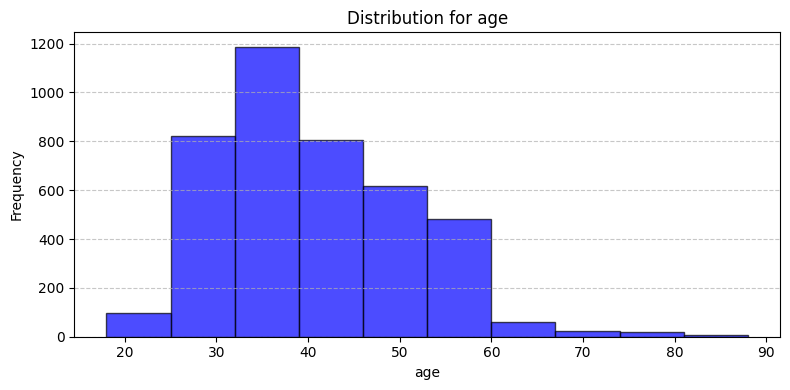

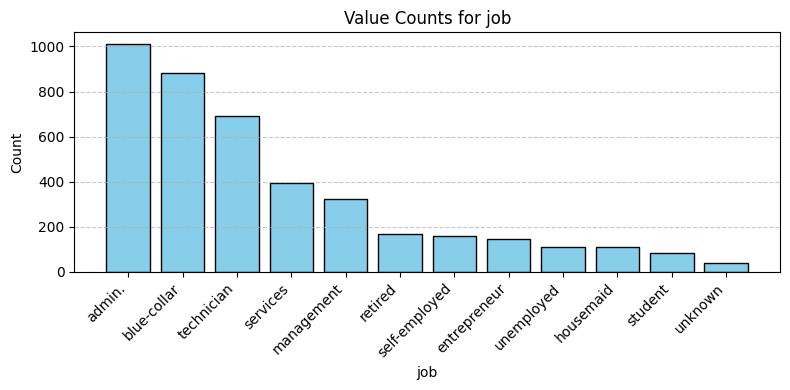

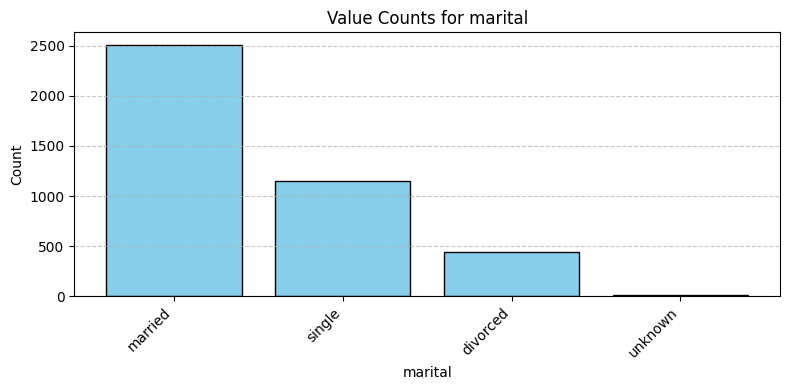

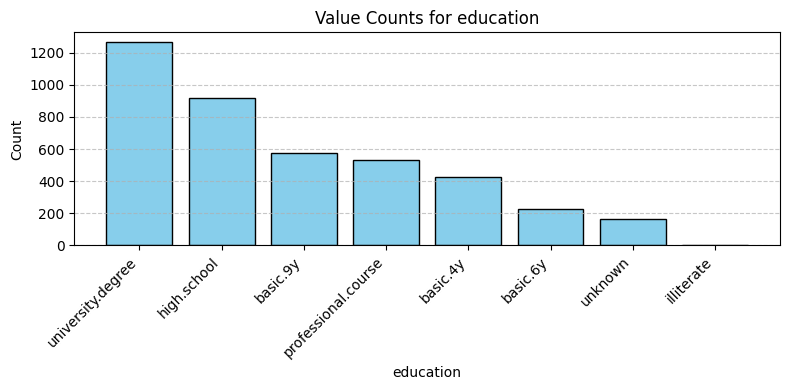

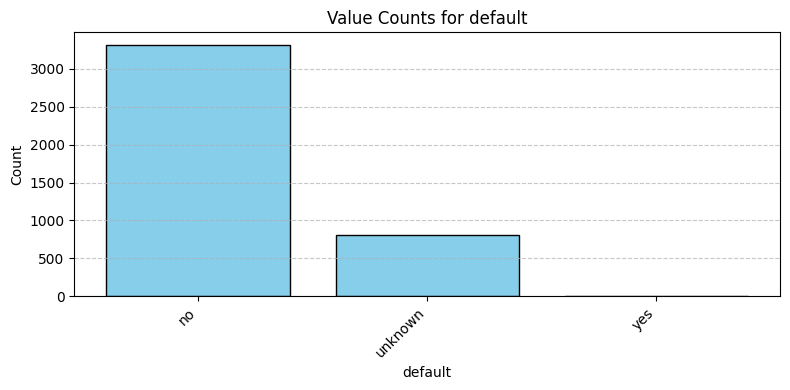

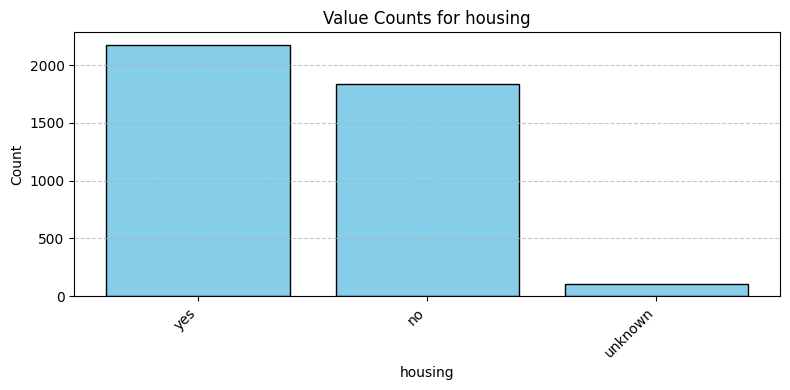

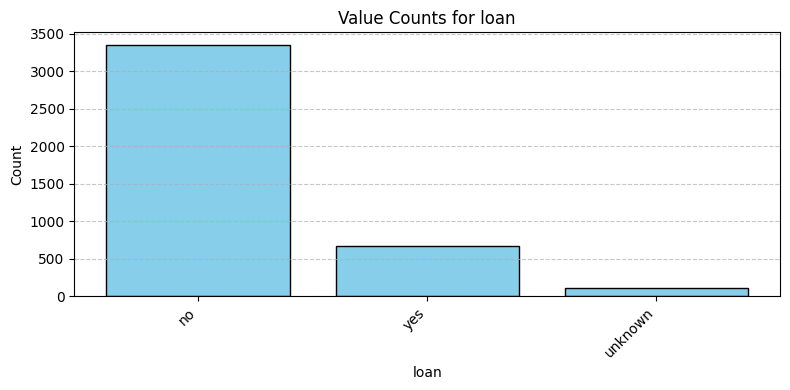

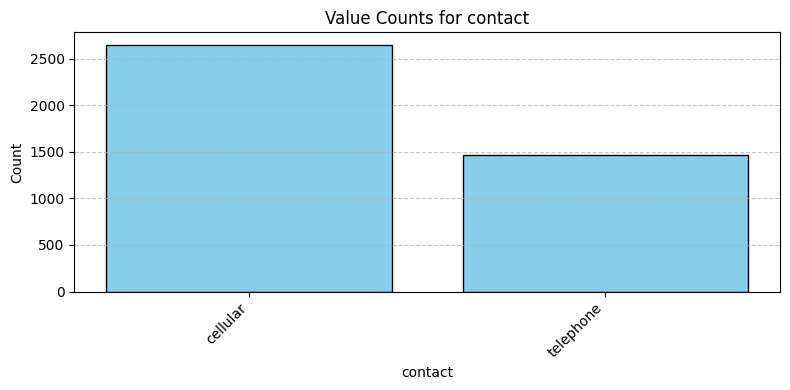

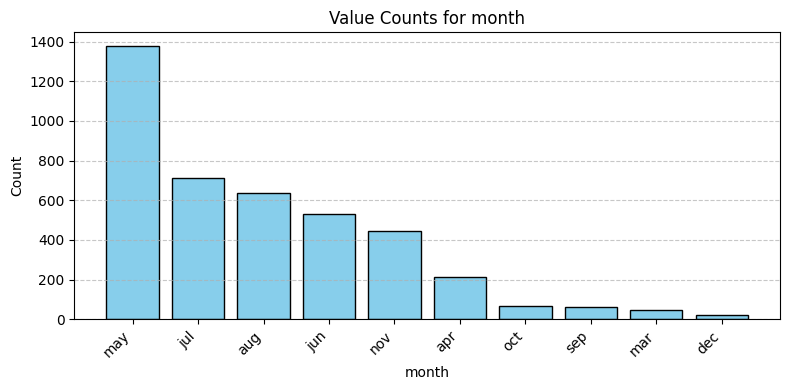

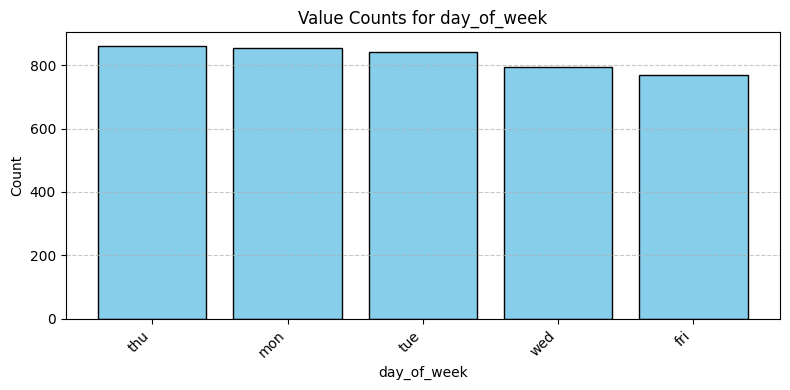

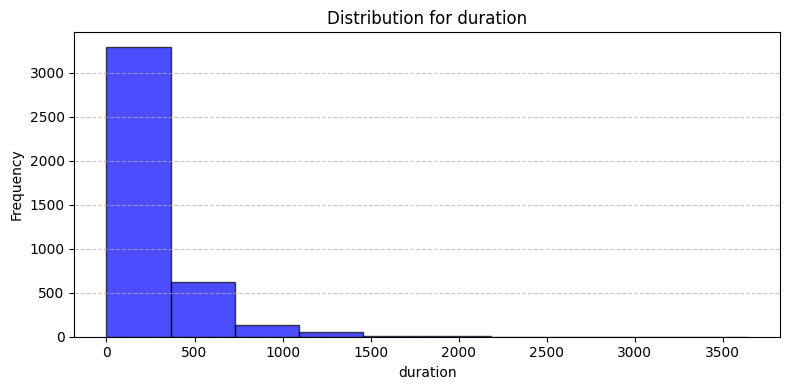

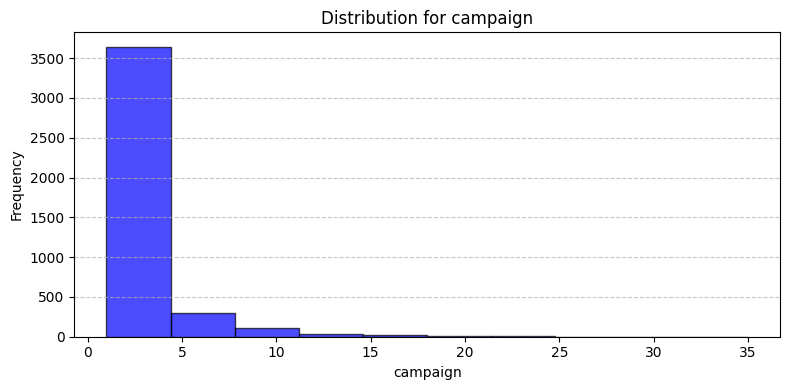

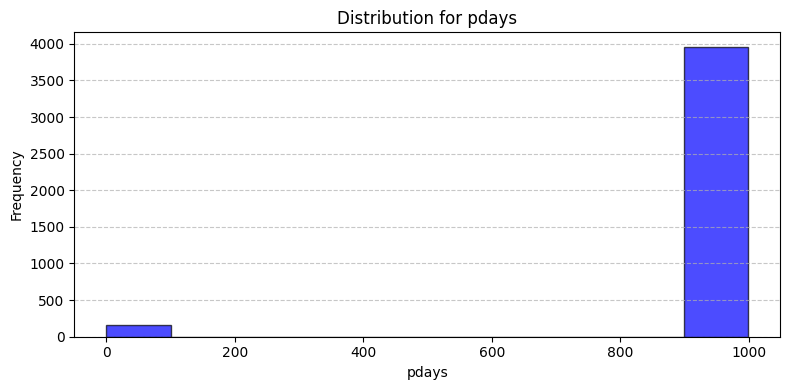

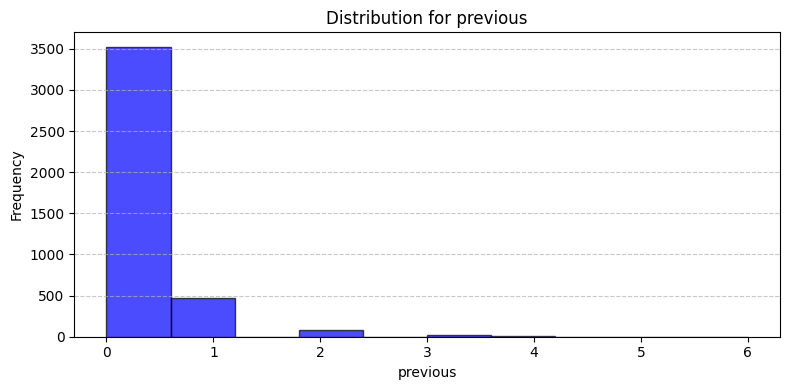

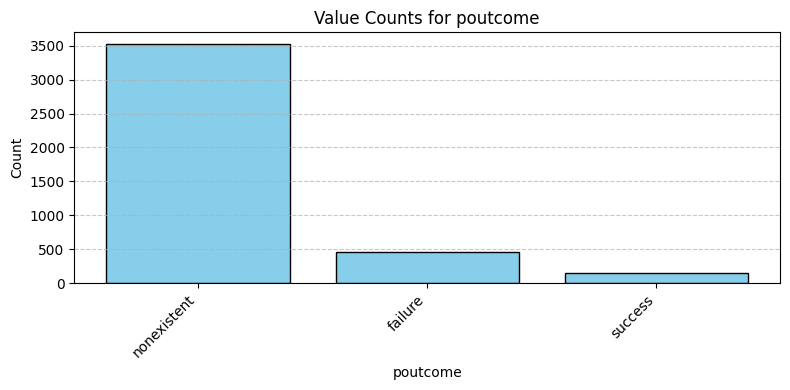

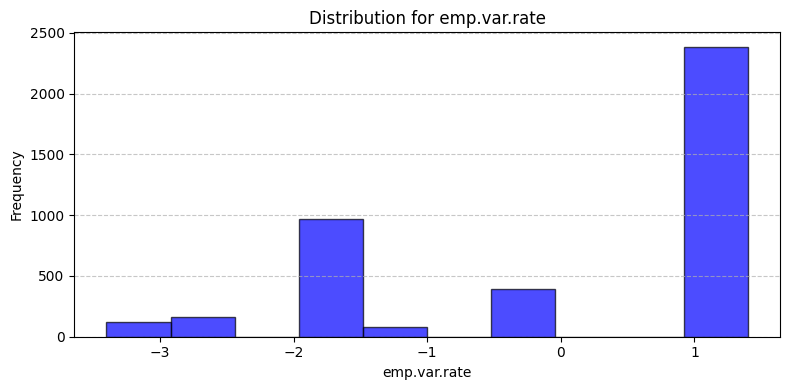

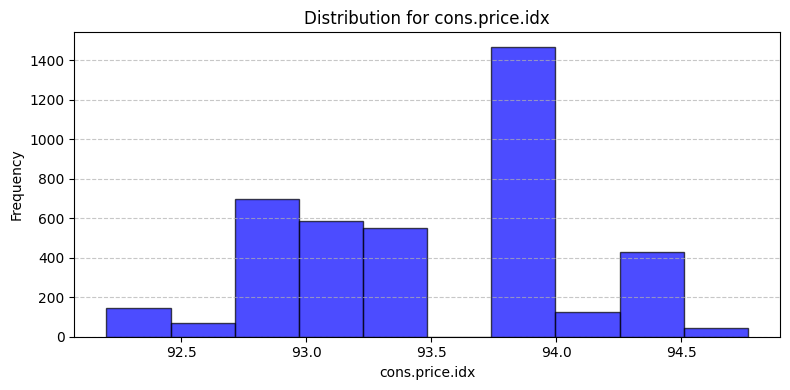

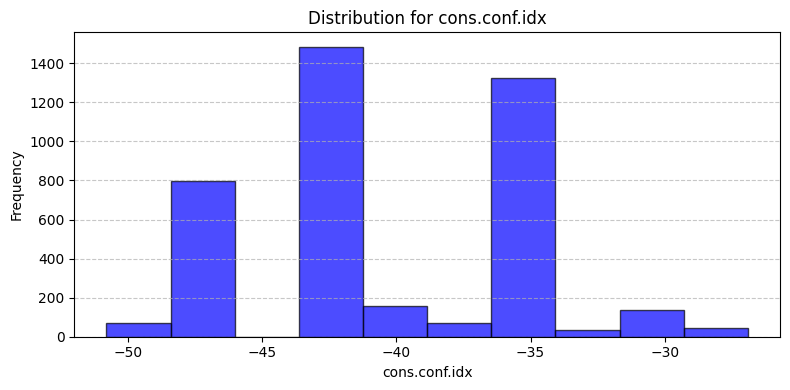

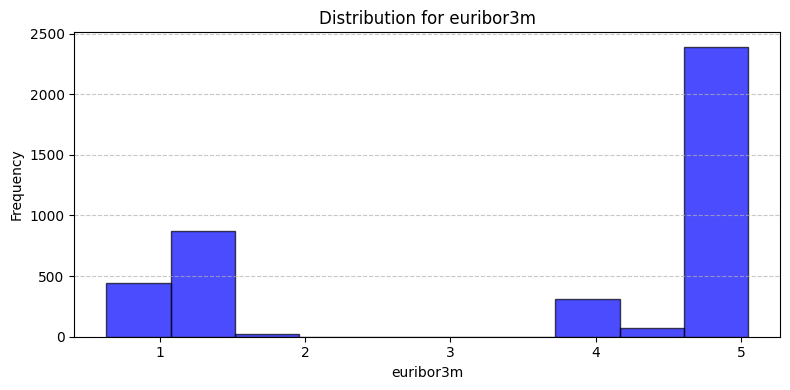

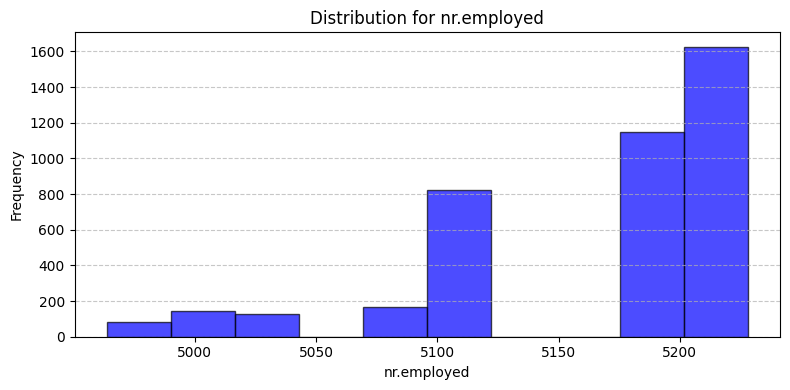

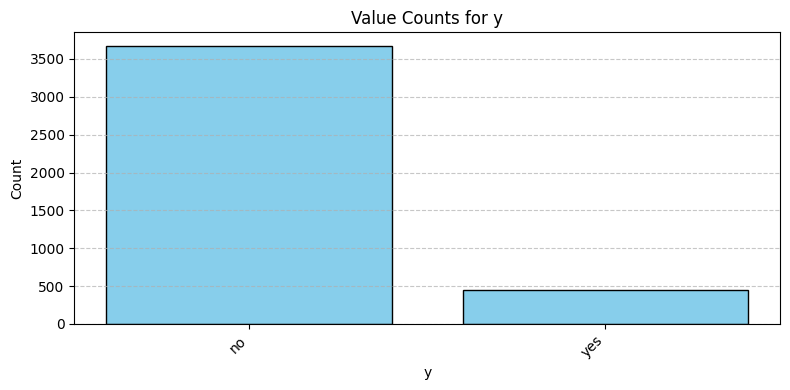

In [271]:
def data_distribution_charts(data) :
    for column in data.columns:
        plt.figure(figsize=(8, 4))
        
        if data[column].dtype == 'object':  # Categorical data
            # Bar plot for value counts
            value_counts = data[column].value_counts()
            plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
            plt.title(f"Value Counts for {column}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45, ha='right')
            
        else:  # Numeric data
            # Histogram for numeric data
            plt.hist(data[column], bins=10, color='blue', edgecolor='black', alpha=0.7)
            plt.title(f"Distribution for {column}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

data_distribution_charts(data)

In [272]:
def print_unique_values(data):
    for column in data.columns:
        unique_values = data[column].unique()
        print(f"Unique values in column '{column}': {unique_values}")

print_unique_values(data)

Unique values in column 'age': [30 39 25 38 47 32 41 31 35 36 29 27 44 46 45 50 55 40 28 34 33 51 48 20
 76 56 24 58 60 37 52 42 49 54 59 57 43 53 75 82 71 21 22 23 26 81 61 67
 73 18 64 74 77 86 85 63 88 78 72 68 80 66 19 62 65 69 70]
Unique values in column 'job': ['blue-collar' 'services' 'admin.' 'entrepreneur' 'self-employed'
 'technician' 'management' 'student' 'retired' 'housemaid' 'unemployed'
 'unknown']
Unique values in column 'marital': ['married' 'single' 'divorced' 'unknown']
Unique values in column 'education': ['basic.9y' 'high.school' 'university.degree' 'professional.course'
 'basic.6y' 'basic.4y' 'unknown' 'illiterate']
Unique values in column 'default': ['no' 'unknown' 'yes']
Unique values in column 'housing': ['yes' 'no' 'unknown']
Unique values in column 'loan': ['no' 'unknown' 'yes']
Unique values in column 'contact': ['cellular' 'telephone']
Unique values in column 'month': ['may' 'jun' 'nov' 'sep' 'jul' 'aug' 'mar' 'oct' 'apr' 'dec']
Unique values in column 'day

In [273]:
def check_column_type(data):
    for column in data.columns:
    # Check if the column is of integer type
        if pd.api.types.is_integer_dtype(data[column]):
            min_val = data[column].min()
            max_val = data[column].max()
            range_size = max_val - min_val + 1
            print(f"Column '{column}' is of integer type. Range size: {range_size}")
        
        elif pd.api.types.is_float_dtype(data[column]):
            min_val = data[column].min()
            max_val = data[column].max()
            range_size = max_val - min_val + 1
            print(f"Column '{column}' is of float type. Range size: {range_size}")
        
        # Check if the column is categorical
        elif data[column].dtype == 'object':
            num_categories = data[column].nunique()
            print(f"Column '{column}' is categorical. Number of categories: {num_categories}")
        
        else:
            print(f"Column '{column}' is neither integer nor categorical.")


check_column_type(data)


Column 'age' is of integer type. Range size: 71
Column 'job' is categorical. Number of categories: 12
Column 'marital' is categorical. Number of categories: 4
Column 'education' is categorical. Number of categories: 8
Column 'default' is categorical. Number of categories: 3
Column 'housing' is categorical. Number of categories: 3
Column 'loan' is categorical. Number of categories: 3
Column 'contact' is categorical. Number of categories: 2
Column 'month' is categorical. Number of categories: 10
Column 'day_of_week' is categorical. Number of categories: 5
Column 'duration' is of integer type. Range size: 3644
Column 'campaign' is of integer type. Range size: 35
Column 'pdays' is of integer type. Range size: 1000
Column 'previous' is of integer type. Range size: 7
Column 'poutcome' is categorical. Number of categories: 3
Column 'emp.var.rate' is of float type. Range size: 5.8
Column 'cons.price.idx' is of float type. Range size: 3.5660000000000025
Column 'cons.conf.idx' is of float type. 

In [274]:
def get_unknown_percentage(df, dataset_name="Data"):
    unknown_percentages = {}
    unknown_columns_count = 0

    # Loop over each column in the dataframe
    for column in df.columns:
        # Count the occurrences of 'unknown' in the column
        unknown_count = (df[column] == 'unknown').sum()

        if column == "pdays":
            unknown_count += (df[column] == 999).sum()

        unknown_count += (df[column].isna()).sum()

        # Calculate the percentage of 'unknown' values
        total_count = len(df[column])
        unknown_percentage = (unknown_count / total_count) * 100

        # Store the percentage in the dictionary
        unknown_percentages[column] = unknown_percentage
        if unknown_percentage > 0:
            unknown_columns_count += 1
            print(f"{dataset_name} - {column} unknowns: {unknown_percentage}%")

    if unknown_columns_count == 0:
        print(f"{dataset_name} - No unknowns in the data.")
    return unknown_percentages

get_unknown_percentage(data)

Data - job unknowns: 0.9468317552804079%
Data - marital unknowns: 0.2670551104637048%
Data - education unknowns: 4.054382131585337%
Data - default unknowns: 19.49502306385045%
Data - housing unknowns: 2.5491624180626364%
Data - loan unknowns: 2.5491624180626364%
Data - pdays unknowns: 96.11556202961884%


{'age': 0.0,
 'job': 0.9468317552804079,
 'marital': 0.2670551104637048,
 'education': 4.054382131585337,
 'default': 19.49502306385045,
 'housing': 2.5491624180626364,
 'loan': 2.5491624180626364,
 'contact': 0.0,
 'month': 0.0,
 'day_of_week': 0.0,
 'duration': 0.0,
 'campaign': 0.0,
 'pdays': 96.11556202961884,
 'previous': 0.0,
 'poutcome': 0.0,
 'emp.var.rate': 0.0,
 'cons.price.idx': 0.0,
 'cons.conf.idx': 0.0,
 'euribor3m': 0.0,
 'nr.employed': 0.0,
 'y': 0.0}

From this investigation of data we can make the following assumptions

numerical that needs to be std:

    age, duration, campaign, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

categorical and should be one hot encoded:

    job, marital, education, contact, poutcome

binary and needs to be transformed

    default, housing, loan, y


lacking enough information, and should be dropped

    pdays

Cyclical and potentially encoded as such, or simply OHE

    day_of_week, month
    



In [275]:
def drop_data(data, columns):
    data = data.drop(columns=columns, axis=1)

    return data

def map_columns(df, columns, mapping):
    for column in columns:
        if column in df.columns:
            df[column] = df[column].map(mapping)
    return df

def one_hot_encode_columns(df, columns):
    # Check if the specified columns exist in the dataframe
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following columns are not in the DataFrame: {', '.join(missing_cols)}")
    
    # Apply one-hot encoding to the specified columns
    df_encoded = pd.get_dummies(df, columns=columns, drop_first=False)

    df_encoded = df_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))
    
    return df_encoded

def encode_cyclic_information(df, column_name, mapping):
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Map the days to numbers
    df[column_name] = df[column_name].map(mapping)
    
    # Create sine and cosine features for cyclic encoding
    df[column_name + '_sin'] = np.sin(2 * np.pi * df[column_name] / 7)
    df[column_name + '_cos'] = np.cos(2 * np.pi * df[column_name] / 7)
    
    # Drop the original day column if you no longer need it
    df = df.drop(columns=[column_name])
    
    return df

def standardize_columns(data, columns):
    scaler = StandardScaler()
    for column in columns : 
        if column in data.columns:
            data[column] = scaler.fit_transform(data[[column]])
    return data

def create_nan_mask(data):
    for column in data.columns:
        if data[column].isna().any():  # Check if the column contains NaN values
            
            mask_column_name = f"{column}_unknown"
            
            data[mask_column_name] = data[column].apply(lambda x: 1 if pd.isna(x) else 0)
            
            column_mode = data[column].mode()
            if not column_mode.empty:
                mode_value = column_mode[0]
            else:
                mode_value = None 
            
            data[column] = data[column].fillna(mode_value)
    
    return data

In [276]:
def preprocessing(url="https://raw.githubusercontent.com/tuclaure/CSU-CS-345/refs/heads/main/Data/bank-additional/bank-additional/bank-additional.csv",mask_nans = True):
    binary_mapping = {
        'yes':1,
        'no':0,
        'unknown': None
        }

    days_mapping = {
            'sun': 0,
            'mon': 1,
            'tue': 2,
            'wed': 3,
            'thu': 4,
            'fri': 5,
            'sat': 6
        }

    months_mapping = {
            'jan': 0,
            'feb': 1,
            'mar': 2,
            'apr': 3,
            'may': 4,
            'jun': 5,
            'jul': 6,
            'aug': 7,
            'sep': 8,
            'oct': 9,
            'nov': 10,
            'dec': 11
        }

    binary_columns = ["default", "housing", "loan", "y"]
    categorical_columns = ["job", "marital", "education", "contact", "poutcome"]
    numerical_columns = ["age", "duration", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
    dropped_columns = ['pdays']

    data = fetch_data(url)
    
    #Remove Duplicate rows
    data = data[~data.duplicated()]

    #Drop necissary features
    data = drop_data(data, dropped_columns)

    #Map Binary values to 0,1,NaN
    data = map_columns(data, binary_columns, binary_mapping)

    #One hot encode categorical data
    data = one_hot_encode_columns(data, categorical_columns)

    # Perform Cyclical mapping for time data
    data = encode_cyclic_information(data, "day_of_week", days_mapping)
    data = encode_cyclic_information(data, "month", months_mapping)
    
    #Standardize Integer Columns
    data = standardize_columns(data, numerical_columns)
    
    if mask_nans :
        data = create_nan_mask(data)
        
    return data

In [277]:
data = preprocessing()
print("--------------")
get_unknown_percentage(data)
print("--------------")
print_unique_values(data)
print("--------------")
check_column_type(data)


--------------
Data - No unknowns in the data.
--------------
Unique values in column 'age': [-0.98075178 -0.10799146 -1.46561862 -0.20496483  0.66779548 -0.78680504
  0.08595527 -0.88377841 -0.49588494 -0.39891157 -1.07772515 -1.27167189
  0.37687538  0.57082212  0.47384875  0.95871559  1.44358243 -0.0110181
 -1.17469852 -0.59285831 -0.68983168  1.05568896  0.76476885 -1.95048547
  3.48002317  1.5405558  -1.56259199  1.73450254  1.92844928 -0.3019382
  1.15266233  0.18292864  0.86174222  1.34660906  1.83147591  1.63752917
  0.27990201  1.2496357   3.38304981  4.06186339  2.99515633 -1.8535121
 -1.75653873 -1.65956536 -1.36864526  3.96489002  2.02542264  2.60726286
  3.18910307 -2.1444322   2.31634275  3.28607644  3.57699654  4.44975686
  4.35278349  2.21936938  4.6437036   3.67396991  3.0921297   2.70423622
  3.86791665  2.51028949 -2.04745884  2.12239601  2.41331612  2.80120959
  2.89818296]
Unique values in column 'default': [0. 1.]
Unique values in column 'housing': [1. 0.]
Unique 

With our data properly preprocessed we will now attempt to solve the imbalanced data set issue through several methods

As discussed earlier in the notebook, this dataset is an example of an imbalanced data. The target feature, “y” (binary “yes” or “no” feature describing whether or not the customer subscribed a term deposit) is heavily imbalanced. There are nearly seven times more yes answers than no's, which leads to interesting challenges when it comes to machine learning on the data.

First is the issue of actually training a model to effectively distinguish between the two classes. Training most models as you would on balanced data will not work, as machine learning models generally intend to minimize the error rate of classification. In the case of imbalanced data, there are so many more of one class than another that models tend to classify every sample into the majority class. A model using this approach will achieve a relatively high accuracy, but in reality is quite poor at being able to tell the two classes apart. In order to combat this, there are methods that can be utilized to train the models more effectively.

The two methods we have explored in this project are cost-sensitive learning and various sampling approaches.

The cost-sensitive methodology is to assign different weights to each class—i.e. assign a higher weight to the minority class. This leads to a greater punishment, or higher cost, for the incorrect classification of the minority class. The model then attempts to minimize the overall cost while training. Cost-sensitive learning helps the model decrease its tendency to over classify samples into the majority class.

Sampling may also be used to reduce the model’s bias towards one class. This is the approach of adjusting class distributions in the training data. You can either oversample the minority class or undersample the majority class.

Oversampling is performed by either duplicating existing samples from the minority class or generating new samples using the patterns found in existing ones. This increases the minority class size and exposes the model to more minority class data. Oversampling has the potential to lead to overfitting, as samples are duplicated/generated using known data, which can cause the model to learn specific patterns instead of generalized rules. However, it can be a quite effective technique to deal with imbalanced data.

In our project, we used the SMOTE class from the imbalanced-learn library to implement the SMOTE technique for oversampling. This method increases minority class distribution by generating synthetic samples from existing ones. SMOTE is used to select a sample and another, neighboring sample from the minority class, then generate a new sample along the line between these two.

Undersampling, or down-sampling, reduces the size of the majority class by removing some values, also making class distribution more balanced. While this can potentially lead to the loss of valuable information, it is also an effective way to handle imbalanced data when utilized correctly.

We used the RandomUnderSampler class from the imbalanced-learn library to randomly choose the subset of the majority class that will be used for training. 

In [278]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pandas as pd

def split_data(data, train_size=0.7, test_size=0.15, val_size=0.15, random_state=42):
    y = data['y']
    X = data.drop(columns=['y'])

    if train_size + test_size + val_size != 1.0:
        raise ValueError("train_size, test_size, and val_size must sum to 1.0")

    # First split X and y into train and temporary (temp) for test + validation
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), random_state=random_state
    )

    # Proportion of test to temp (test + validation)
    test_ratio = test_size / (test_size + val_size)

    # Split temp into test and validation
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp, y_temp, test_size=test_ratio, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

def undersample_data(X_train, y_train, random_state=42):
    # Separate majority and minority classes
    majority = X_train[y_train == y_train.value_counts().idxmax()]
    minority = X_train[y_train != y_train.value_counts().idxmax()]
    
    # Downsample majority class
    majority_downsampled = resample(
        majority,
        replace=False,  # No replacement
        n_samples=len(minority),  # Match minority size
        random_state=random_state  # Reproducibility
    )
    
    # Combine and shuffle
    X_train_balanced = pd.concat([majority_downsampled, minority]).sample(frac=1, random_state=random_state)
    y_train_balanced = y_train[X_train_balanced.index]
    
    return X_train_balanced, y_train_balanced

def oversample_data(X_train, y_train, random_state=42):
    # Separate majority and minority classes
    majority = X_train[y_train == y_train.value_counts().idxmax()]
    minority = X_train[y_train != y_train.value_counts().idxmax()]
    
    # Upsample minority class
    minority_upsampled = resample(
        minority,
        replace=True,  # Allow replacement
        n_samples=len(majority),  # Match majority size
        random_state=random_state  # Reproducibility
    )
    
    # Combine and shuffle
    X_train_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=random_state)
    y_train_balanced = y_train[X_train_balanced.index]
    
    return X_train_balanced, y_train_balanced

def combined_sampling(X_train, y_train, random_state=42):
    # Separate majority and minority classes
    majority = X_train[y_train == y_train.value_counts().idxmax()]
    minority = X_train[y_train != y_train.value_counts().idxmax()]
    
    # Downsample majority class
    majority_downsampled = resample(
        majority,
        replace=False,
        n_samples=len(minority) * 2,  # Reduce to twice the size of minority
        random_state=random_state
    )
    
    # Upsample minority class
    minority_upsampled = resample(
        minority,
        replace=True,
        n_samples=len(majority_downsampled),  # Match new majority size
        random_state=random_state
    )
    
    # Combine and shuffle
    X_train_balanced = pd.concat([majority_downsampled, minority_upsampled]).sample(frac=1, random_state=random_state)
    y_train_balanced = y_train[X_train_balanced.index]
    
    return X_train_balanced, y_train_balanced

def smote_sampling(X_train, y_train, random_state=42):
    smote = SMOTE(random_state=random_state)
    
    # Apply SMOTE
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    return X_smote, y_smote

def calculate_class_weights(data, target_column='y'):
    from sklearn.utils.class_weight import compute_class_weight
    
    # Compute weights
    classes = data[target_column].unique()
    weights = compute_class_weight('balanced', classes=classes, y=data[target_column])
    
    # Return a dictionary of weights
    return dict(zip(classes, weights))

def get_sampled_train_data(X_train, y_train, random_state=42):
    return {
        "Original": (X_train, y_train),
        "Undersample": undersample_data(X_train, y_train, random_state),
        "Oversample": oversample_data(X_train, y_train, random_state),
        "Combined Sampling": combined_sampling(X_train, y_train, random_state),
        "SMOTE": smote_sampling(X_train, y_train, random_state)
    }


Because we have an imbalanced data set, even with resampling standard metrics arent as indicitive of success, so we will use the following

Another issue that arises due to the imbalanced nature of this dataset is the evaluation of trained models. Normally, measuring the performance of a machine learning model is quite simple: Measure the accuracy of the model on a test set of data. Unfortunately, it is not as easy with imbalanced data. A naive model trained on imbalanced data, which simply categorizes all of the samples into the majority class, will still achieve a high accuracy on a training set of equally imbalanced data. Because the model assumes all samples are of the majority class, and most of them are, its predictions will be mainly correct. But the model is useless when it comes to actually distinguishing between classes.

This is where alternate evaluation metrics, such as the F1 score and Precision-Recall AUC, come into play.

The F1 Score is the average between recall and precision of a model’s performance. Recall, when predicting whether a sample belongs to a class or not, is the proportion of actual positives that were correctly identified. Precision is the proportion of the positives identified that were correctly deemed positive. The F1 score balances the trade-off between these two metrics, focusing on the performance of the model with respect to the minority class.

The Precision-Recall curve is a curve that plots precision against recall at different decision thresholds (probability values at which the model decides to classify a sample as one or the other class). The PR-AUC is the area under this curve, and ranges from zero to one. The higher the PR-AUC, the better the model is at predicting the minority class.

The F1 score is essentially one point on the PR-curve. It evaluates the model based on precision and recall at a given threshold, so is a good evaluation of models at a default threshold. The PR-AUC gives a more comprehensive look at the model’s performance over many thresholds. Both metrics can be used together to give an informative performance measurement of a model. This is what we have done in our project.


In [279]:
#Given a model and a Train and Test set, returns
def evaluate_model(model, X_test, y_test):
    # Predict the probabilities and classes
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # probability of positive class for ROC and PR curve
    
    # Calculate AUC - ROC
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Calculate AUC - Precision-Recall (PR)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    confusion = confusion_matrix(y_test, y_pred)

    classification = classification_report(y_test, y_pred)
    
    results = {
        'accuracy': accuracy,
        'f1': f1,
        'roc': roc_auc,
        'pr': pr_auc,
        'confusion': confusion,
        'classification': classification
    }
    
    return results

def print_formatted_results(results):
    # Storage for best metrics
    best_metrics = {
        "accuracy": {"value": 0, "method": "", "weighting": ""},
        "f1": {"value": 0, "method": "", "weighting": ""},
        "roc": {"value": 0, "method": "", "weighting": ""},
        "pr": {"value": 0, "method": "", "weighting": ""}
    }
    
    for method, evaluations in results.items():
        print(f"Sampling Method: {method}")
        print("=" * 50)
        for weighting, metrics in evaluations.items():
            print(f"  {weighting}")
            print("  " + "-" * 48)
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    F1 Score: {metrics['f1']:.4f}")
            print(f"    ROC AUC: {metrics['roc']:.4f}")
            print(f"    PR AUC: {metrics['pr']:.4f}")
            print(f"    Confusion Matrix:\n{metrics['confusion']}")
            print(f"    Classification Report:\n{metrics['classification']}")
            print("-" * 50)
            
            # Update best metrics
            for metric in best_metrics.keys():
                if metrics[metric] > best_metrics[metric]["value"]:
                    best_metrics[metric] = {
                        "value": metrics[metric],
                        "method": method,
                        "weighting": weighting
                    }
        print("\n")

    # Print summary of best metrics
    print("\nBest Models Summary")
    print("=" * 50)
    for metric, details in best_metrics.items():
        print(f"Best {metric.upper()}:")
        print(f"  Value: {details['value']:.4f}")
        print(f"  Method: {details['method']}")
        print(f"  Weighting: {details['weighting']}")
        print("-" * 50)

# Assuming `results` contains the output from `evaluate_svc_with_sampling`


In [280]:
def evaluate_svm_with_weighting_and_sampling(data, random_state=42):
    # Split the data
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(data, random_state=random_state)
    
    # Get class weights
    class_weights = calculate_class_weights(data)

    # Get the sampled data
    sampled_data = get_sampled_train_data(X_train, y_train, random_state=random_state)

    results = {}

    # Loop through each sampling method and class weight type
    for method, (X_train_sampled, y_train_sampled) in sampled_data.items():
        # Initialize results for this method
        results[method] = {}

        for weighting_type, class_weight in class_weights.items():
            # Set class_weight dictionary for SVM
            class_weight_dict = {0: class_weight, 1: 1}  # Adjust based on your class labels
            
            # Initialize SVM model with the specified class weights
            svm = SVC(class_weight=class_weight_dict, random_state=random_state, probability=True)

            svm.fit(X_train_sampled, y_train_sampled)
            # Evaluate the model
            eval_results = evaluate_model(svm, X_test, y_test)

            # Store the results for this method and weighting
            results[method][weighting_type] = eval_results

    return results

data = preprocessing()
results = evaluate_svm_with_weighting_and_sampling(data)
print_formatted_results(results)


Sampling Method: Original
  0.0
  ------------------------------------------------
    Accuracy: 0.9013
    F1 Score: 0.5481
    ROC AUC: 0.9284
    PR AUC: 0.5340
    Confusion Matrix:
[[520  36]
 [ 25  37]]
    Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       556
         1.0       0.51      0.60      0.55        62

    accuracy                           0.90       618
   macro avg       0.73      0.77      0.75       618
weighted avg       0.91      0.90      0.90       618

--------------------------------------------------
  1.0
  ------------------------------------------------
    Accuracy: 0.9061
    F1 Score: 0.2162
    ROC AUC: 0.8701
    PR AUC: 0.4548
    Confusion Matrix:
[[552   4]
 [ 54   8]]
    Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       556
         1.0       0.67      0.13      0.22        62

    accuracy

In [ ]:
def evaluate_rf_with_weighting_and_sampling(data, random_state=42):
    # Split the data
    X_train, X_test, X_val, y_train, y_test, y_val = split_data(data, random_state=random_state)
    
    # Get class weights
    class_weights = calculate_class_weights(data)

    # Get the sampled data
    sampled_data = get_sampled_train_data(X_train, y_train, random_state=random_state)

    results = {}

    # Loop through each sampling method and class weight type
    for method, (X_train_sampled, y_train_sampled) in sampled_data.items():
        # Initialize results for this method
        results[method] = {}

        for weighting_type, class_weight in class_weights.items():
            # Set class_weight dictionary for Random Forest
            class_weight_dict = {0: class_weight, 1: 1}  # Adjust based on your class labels
            
            # Initialize Random Forest model with the specified class weights
            rf = RandomForestClassifier(class_weight=class_weight_dict, random_state=random_state)

            # Evaluate the model
            eval_results = evaluate_model(rf, X_train_sampled, X_test, y_train_sampled, y_test)

            # Store the results for this method and weighting
            results[method][weighting_type] = eval_results

    return results

data = preprocessing()
results = evaluate_rf_with_weighting_and_sampling(data)
print_formatted_results(results)


Sampling Method: Original
  0.0
  ------------------------------------------------
    Accuracy: 0.9110
    F1 Score: 0.4762
    ROC AUC: 0.9198
    PR AUC: 0.5372
    Confusion Matrix:
[[538  18]
 [ 37  25]]
    Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       556
         1.0       0.58      0.40      0.48        62

    accuracy                           0.91       618
   macro avg       0.76      0.69      0.71       618
weighted avg       0.90      0.91      0.90       618

--------------------------------------------------
  1.0
  ------------------------------------------------
    Accuracy: 0.9094
    F1 Score: 0.5000
    ROC AUC: 0.9123
    PR AUC: 0.5068
    Confusion Matrix:
[[534  22]
 [ 34  28]]
    Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       556
         1.0       0.56      0.45      0.50        62

    accuracy